# Mount Drive



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries and initializing stopwords and stemmer


In [ ]:
import pandas as pd
import numpy as np
from glob import glob
import re
import json

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
english_stopwords = stopwords.words("english")
english_stemmer = SnowballStemmer("english")


# Reading Data


In [ ]:
hasoc_data = pd.read_csv("drive/MyDrive/ICHCL_baseline/hasoc2021-train/Hasoc2021_train.csv") #Your respective address
hasoc_data.head()


,Unnamed: 0,_id,text,task_1,task_2
0,4986,60c5d6bf5659ea5e55defa2c,@wealth if you made it through this &amp;&amp;...,HOF,PRFN
1,3394,60c5d6bf5659ea5e55def461,Technically that's still turning back the cloc...,HOF,OFFN
2,1310,60c5d6bf5659ea5e55defaad,@VMBJP @BJP4Bengal @BJP4India @narendramodi @J...,NOT,NONE
3,3390,60c5d6bf5659ea5e55def419,@krtoprak_yigit Soldier of Japan Who has dick ...,HOF,OFFN
4,4626,60c5d6bf5659ea5e55def7fa,@blueheartedly You'd be better off asking who ...,HOF,OFFN


In [ ]:
hasoc_data.describe()

,Unnamed: 0
count,3843.000000
mean,2558.799375
std,1477.088070
min,1.000000
25%,1276.500000
50%,2574.000000
75%,3828.000000
max,5121.000000


In [ ]:
tweets = hasoc_data.text
y_task1 = hasoc_data.task_1
y_task2 = hasoc_data.task_2

# Basic Preprocessing of Tweets


In [ ]:
def clean_tweet(tweet):
    tweet = re.sub(r"@[A-Za-z0-9]+",' ', tweet)
    tweet = re.sub(r"https?://[A-Za-z0-9./]+",' ', tweet)
    tweet = re.sub("RT ", " ", tweet)
    tweet = re.sub("\n", " ", tweet)
    tweet = re.sub(r" +", " ", tweet)
    tokens = []
    for token in tweet.split():
        if token not in english_stopwords:
            token = english_stemmer.stem(token)     # Stemming words like programming programmer to program - May need to remove this in future
            tokens.append(token)
    return " ".join(tokens)

In [ ]:
cleaned_tweets = [clean_tweet(tweet) for tweet in tweets]

Using TF-IDF for featuring the text. The vectorizer will only consider vocab terms that appear in more than 5 documents.

In [ ]:
vectorizer = TfidfVectorizer(min_df = 5)
X = vectorizer.fit_transform(cleaned_tweets)
X = X.todense()

#Training and evaluating model

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y_task1, test_size=0.2, random_state=42)

Simple Logistic Regression Model

In [ ]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = classifier.predict(X_val)


In [ ]:
print(classification_report(y_val, y_pred))


              precision    recall  f1-score   support

         HOF       0.80      0.91      0.85       529
         NOT       0.72      0.49      0.58       240

    accuracy                           0.78       769
   macro avg       0.76      0.70      0.72       769
weighted avg       0.77      0.78      0.77       769



In [ ]:
le = LabelEncoder() #label encoding labels for training Dense Neural Network
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

Deep Learning Model 

In [ ]:
model = Sequential(
    [
        Dense(64, activation="relu"),
        Dense(32, activation="relu"),
        Dense(1, activation="sigmoid"),
    ]
)
model.compile('adam', loss='binary_crossentropy', metrics = ['accuracy']) #compiling a neural network with 3 layers for classification

In [ ]:
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)
# Use this for saving weights etc after training


In [30]:
val_set = [X_val,y_val]

In [32]:
history = model.fit(X_train, y_train, epochs = 100, batch_size = 32) # Add callbacks=[model_checkpoint_callback] to the function to save

Epoch 1/100
97/97 [==============================] - 0s 3ms/step - loss: 0.0062 - accuracy: 0.9951
Epoch 2/100
97/97 [==============================] - 0s 3ms/step - loss: 0.0062 - accuracy: 0.9951
Epoch 3/100
97/97 [==============================] - 0s 3ms/step - loss: 0.0060 - accuracy: 0.9954
Epoch 4/100
97/97 [==============================] - 0s 3ms/step - loss: 0.0060 - accuracy: 0.9958
Epoch 5/100
97/97 [==============================] - 0s 3ms/step - loss: 0.0058 - accuracy: 0.9958
Epoch 6/100
97/97 [==============================] - 0s 3ms/step - loss: 0.0058 - accuracy: 0.9961
Epoch 7/100
97/97 [==============================] - 0s 3ms/step - loss: 0.0060 - accuracy: 0.9961
Epoch 8/100
97/97 [==============================] - 0s 3ms/step - loss: 0.0059 - accuracy: 0.9961
Epoch 9/100
97/97 [==============================] - 0s 3ms/step - loss: 0.0058 - accuracy: 0.9958
Epoch 10/100
97/97 [==============================] - 0s 3ms/step - loss: 0.0059 - accuracy: 0.9951
Epoch 11/

In [ ]:
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5).astype('int64')
y_pred = y_pred.reshape(len(y_pred))    

In [ ]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       529
           1       0.54      0.62      0.58       240

    accuracy                           0.72       769
   macro avg       0.68      0.69      0.68       769
weighted avg       0.73      0.72      0.72       769



# Plots


In [23]:
import matplotlib.pyplot as plt

In [26]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string,'val_'+ string])
  plt.show()

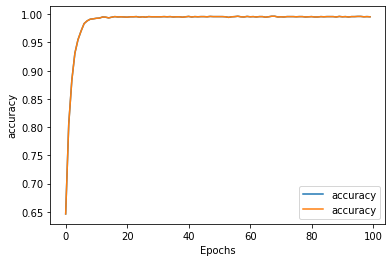

In [27]:
plot_graphs(history, 'accuracy')

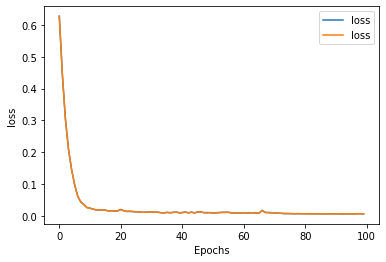

In [28]:
plot_graphs(history, 'loss')


#Prediction of test set and submission file generation


In [ ]:
hasoc_test = pd.read_csv("drive/MyDrive/ICHCL_baseline/hasoc2021-train/Hasoc2021_test.csv") # Not yet released
hasoc_test.head()

In [ ]:
tweets_test = hasoc_test.text
tweet_ids = hasoc_test.tweet_id
y_test_task1 = hasoc_test.task_1
y_test_task2 = hasoc_test.task_2

In [ ]:
cleaned_test_tweets = [clean_tweet(tweet) for tweet in tweets_test]

In [ ]:
X_test = vectorizer.fit_transform(cleaned_test_tweets)
X_test = X_test.todense()

In [ ]:
submission_prediction = classifier.predict(X_test)
submission = {'tweet_id': tweet_ids, 'label':submission_prediction}
submission = pd.DataFrame(submission)

In [ ]:
submission.to_csv('data/sample_submission.csv', index = False)